In [ ]:
# Project: Linear regression mini-project (scikit-learn)
# Run in a single notebook cell-blocks sequentially.
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer histograms (not required)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# 1) Load data + quick EDA
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y = data.frame["MedHouseVal"]

print("Shape:", X.shape)
print("Columns:", list(X.columns))
print("Target summary:\n", y.describe())
# Quick check for missing values
print("Missing values per column:\n", X.isna().sum())

Shape: (20640, 8)
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target summary:
 count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64
Missing values per column:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
# 2) Train / Test split (strict hold-out)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])

Train / Test sizes: 16512 4128


In [ ]:
# 3) Pipeline: scaling + linear model
pipe_lin = Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())])

pipe_ridge = Pipeline(
    [("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_SEED))]
)

In [8]:
# 4) Fit baseline LinearRegression
pipe_lin.fit(X_train, y_train)
y_train_pred = pipe_lin.predict(X_train)
y_test_pred = pipe_lin.predict(X_test)

In [ ]:
# 5) Evaluate (helper)
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}


print("TRAIN metrics:", regression_metrics(y_train, y_train_pred))
print("TEST  metrics:", regression_metrics(y_test, y_test_pred))

TRAIN metrics: {'MSE': 0.5179331255246699, 'RMSE': np.float64(0.7196757085831575), 'MAE': 0.5286283596581935, 'R2': 0.6125511913966952}
TEST  metrics: {'MSE': 0.5558915986952444, 'RMSE': np.float64(0.7455813830127764), 'MAE': 0.5332001304956565, 'R2': 0.5757877060324508}


In [ ]:
# 6) Quick regularization sweep (Ridge) — small grid CV
alphas = np.logspace(-3, 3, 7)
param_grid = {"model__alpha": alphas}
gs = GridSearchCV(
    pipe_ridge, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1
)
gs.fit(X_train, y_train)
print("Best alpha:", gs.best_params_)
best_ridge = gs.best_estimator_

# Evaluate best ridge on test
y_test_pred_ridge = best_ridge.predict(X_test)
print("Ridge TEST metrics:", regression_metrics(y_test, y_test_pred_ridge))

Best alpha: {'model__alpha': np.float64(0.001)}
Ridge TEST metrics: {'MSE': 0.5558915618350118, 'RMSE': np.float64(0.7455813582936551), 'MAE': 0.53320012333683, 'R2': 0.5757877341612512}


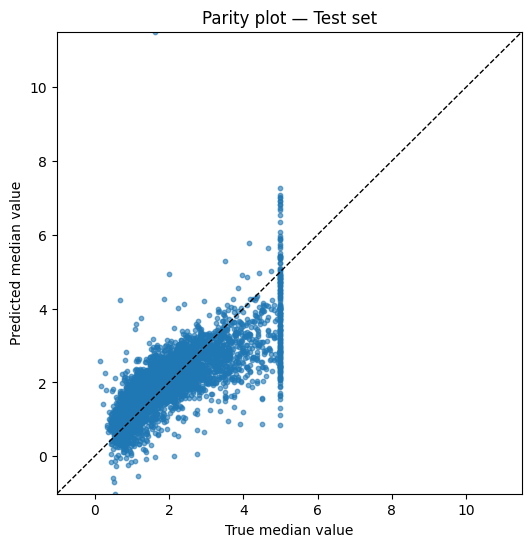

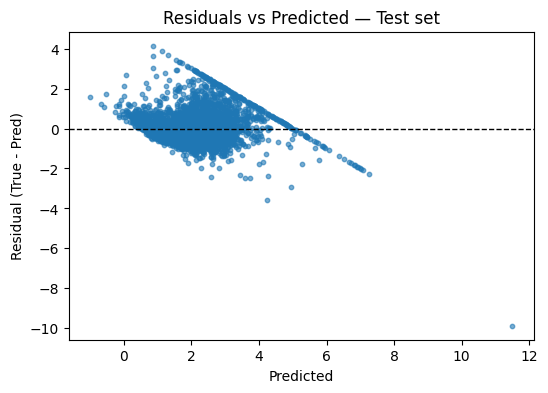

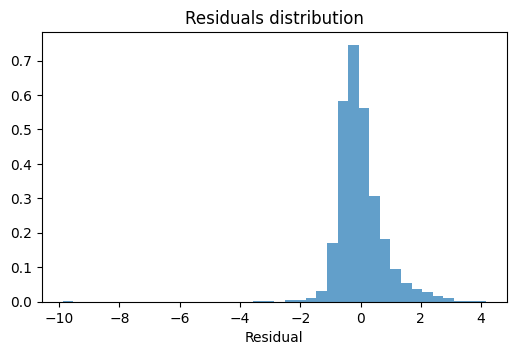

In [ ]:
# 7) Essential plots (parity + residuals)
# Parity plot (y_true vs y_pred) - Test set
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=10)
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True median value")
plt.ylabel("Predicted median value")
plt.title("Parity plot — Test set")
plt.show()

# Residuals vs Predicted
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred, residuals, alpha=0.6, s=10)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted — Test set")
plt.show()

# Optional: histogram of residuals (quick normality check)
plt.figure(figsize=(6, 3.5))
plt.hist(residuals, bins=40, density=True, alpha=0.7)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.show()

In [ ]:
# 🔹 Step 1. Polynomial + Ridge Pipeline Setup
from sklearn.preprocessing import PolynomialFeatures

pipe_poly = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("model", Ridge(random_state=RANDOM_SEED)),
    ]
)

In [ ]:
# 🔹 Step 2. Hyperparameter Search (Ridge α)
alphas = np.logspace(-3, 3, 7)  # 0.001 → 1000
param_grid = {"model__alpha": alphas}

gs_poly = GridSearchCV(
    pipe_poly,
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
)
gs_poly.fit(X_train, y_train)
print("Best alpha:", gs_poly.best_params_)
best_poly = gs_poly.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best alpha: {'model__alpha': np.float64(1000.0)}


In [ ]:
# 🔹 Step 3. Evaluate on Train/Test
y_train_pred_poly = best_poly.predict(X_train)
y_test_pred_poly = best_poly.predict(X_test)

print("TRAIN metrics:", regression_metrics(y_train, y_train_pred_poly))
print("TEST  metrics:", regression_metrics(y_test, y_test_pred_poly))

TRAIN metrics: {'MSE': 0.510995363887171, 'RMSE': np.float64(0.7148393972684851), 'MAE': 0.5262151819610257, 'R2': 0.6177411036621052}
TEST  metrics: {'MSE': 0.5693416076292618, 'RMSE': np.float64(0.7545472865429057), 'MAE': 0.5298961449594928, 'R2': 0.5655237280245522}


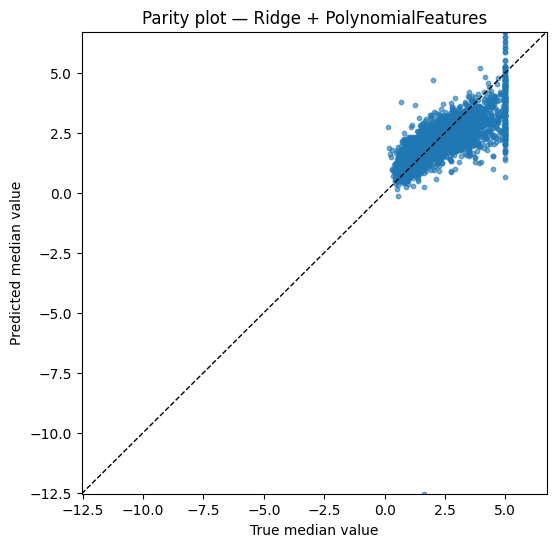

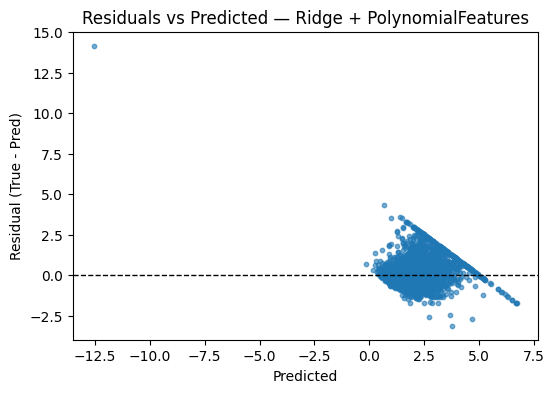

In [ ]:
# 🔹 Step 4. Inspect Plots Again (same visuals)
# Parity plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_poly, alpha=0.6, s=10)
lims = [
    min(y_test.min(), y_test_pred_poly.min()),
    max(y_test.max(), y_test_pred_poly.max()),
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True median value")
plt.ylabel("Predicted median value")
plt.title("Parity plot — Ridge + PolynomialFeatures")
plt.show()

# Residuals vs Predicted
residuals_poly = y_test - y_test_pred_poly
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred_poly, residuals_poly, alpha=0.6, s=10)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted — Ridge + PolynomialFeatures")
plt.show()